In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import talib

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
idx = pd.IndexSlice

In [12]:
DATA_DIR = Path('data')

prices = (pd.read_hdf(DATA_DIR / 'assets.h5', 'stooq/jp/tse/stocks/prices')
          .loc[idx[:, '2010': '2023'], :].loc[lambda df: ~df.index.duplicated(), :])

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 9999276 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    9999276 non-null  float64
 1   high    9999276 non-null  float64
 2   low     9999276 non-null  float64
 3   close   9999276 non-null  float64
 4   volume  9999276 non-null  float64
dtypes: float64(5)
memory usage: 419.9+ MB


In [14]:
before = len(prices.index.unique('ticker').unique())
before

3889

In [15]:
# dropna(axis=1) if missing values are over 5
prices = (prices.unstack('ticker').sort_index().ffill(limit=5).dropna(axis=1).stack('ticker').swaplevel())

prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7014411 entries, ('1301.JP', Timestamp('2010-01-04 00:00:00')) to ('9997.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    7014411 non-null  float64
 1   high    7014411 non-null  float64
 2   low     7014411 non-null  float64
 3   close   7014411 non-null  float64
 4   volume  7014411 non-null  float64
dtypes: float64(5)
memory usage: 294.6+ MB


In [19]:
prices.tail()

,,open,high,low,close,volume
ticker,date,,,,,
9991.JP,2023-05-01,896.0,901.0,884.0,889.0,23000.0
9993.JP,2023-05-01,1276.0,1285.0,1276.0,1280.0,2300.0
9994.JP,2023-05-01,2680.0,2686.0,2670.0,2683.0,6500.0
9996.JP,2023-05-01,1206.0,1216.0,1205.0,1212.0,3700.0
9997.JP,2023-05-01,749.0,753.0,741.0,746.0,131200.0


In [22]:
after = len(prices.index.unique('ticker').unique())
f'before drop data: {before}, after drop data: {after}'

'before drop data: 3889, after drop data: 2151'

In [26]:
dv = prices.close.mul(prices.volume)
keep = dv.groupby('ticker').median().nlargest(1000).index.tolist()

prices = prices.loc[idx[keep,:],:]
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3261000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('3053.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    3261000 non-null  float64
 1   high    3261000 non-null  float64
 2   low     3261000 non-null  float64
 3   close   3261000 non-null  float64
 4   volume  3261000 non-null  float64
dtypes: float64(5)
memory usage: 137.1+ MB


In [29]:
intervals = [1, 5, 10, 21, 63]
returns = []
by_ticker = prices.groupby(level='ticker').close
for t in intervals:
    returns.append(by_ticker.pct_change(t).to_frame(f'ret_{t}'))

returns = pd.concat(returns, axis=1)
returns.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3261000 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('3053.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   ret_1   3260000 non-null  float64
 1   ret_5   3256000 non-null  float64
 2   ret_10  3251000 non-null  float64
 3   ret_21  3240000 non-null  float64
 4   ret_63  3198000 non-null  float64
dtypes: float64(5)
memory usage: 137.1+ MB


In [31]:
max_ret_by_sym = returns.groupby(level='ticker').max()
max_ret_by_sym

,ret_1,ret_5,ret_10,ret_21,ret_63
ticker,,,,,
1332.JP,0.185714,0.438788,0.515559,0.605097,0.945862
1377.JP,0.156322,0.223664,0.363451,0.401947,0.505448
1379.JP,0.075628,0.172934,0.193141,0.209336,0.271009
1407.JP,0.236236,0.538797,1.323413,1.171833,2.330086
1414.JP,0.229371,0.279004,0.347079,0.394127,0.498483
...,...,...,...,...,...
9983.JP,0.180769,0.283556,0.303602,0.473768,0.683989
9984.JP,0.189522,0.446593,0.396814,0.792806,1.057425
9987.JP,0.106368,0.210972,0.342643,0.291713,0.492360


In [33]:
percentiles = [.001, .005, .01, .025, .05, .1]
percentiles += [1-p for p in percentiles]
max_ret_by_sym.describe(percentiles=sorted(percentiles))

,ret_1,ret_5,ret_10,ret_21,ret_63
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.184425,0.388126,0.510536,0.666226,1.073888
std,0.089839,0.313610,0.527661,0.802677,1.458066
min,0.071801,0.116461,0.153498,0.151379,0.217566
0.1%,0.072029,0.134310,0.161632,0.169727,0.270956
0.5%,0.080410,0.144160,0.170213,0.209329,0.318688
1%,0.085877,0.149991,0.184432,0.224230,0.338053
2.5%,0.092887,0.166471,0.209282,0.237691,0.364245
5%,0.097595,0.179280,0.219265,0.255845,0.391611
10%,0.105759,0.195260,0.236739,0.280851,0.427471


In [36]:
quantiles = max_ret_by_sym.quantile(.95)
to_drop = []
for ret, q in quantiles.items():
    to_drop.extend(max_ret_by_sym[max_ret_by_sym[ret]>q].index.tolist())

to_drop = pd.Series(to_drop).value_counts()
to_drop = to_drop[to_drop > 1].index.to_list()
len(to_drop)

55

In [38]:
prices = prices.drop(to_drop, level='ticker')
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3081645 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('3053.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    3081645 non-null  float64
 1   high    3081645 non-null  float64
 2   low     3081645 non-null  float64
 3   close   3081645 non-null  float64
 4   volume  3081645 non-null  float64
dtypes: float64(5)
memory usage: 129.6+ MB


In [40]:
returns = []
by_sym = prices.groupby(level='ticker').close
for t in intervals:
    ret = by_sym.pct_change(t)
    rel_perc = (ret.groupby(level='ticker').apply(lambda x: pd.qcut(x, q=20, labels=False, duplicates='drop')))
    returns.extend([ret.to_frame(f'ret_{t}'), rel_perc.to_frame(f'ret_rel_perc_{t}')])
returns = pd.concat(returns, axis=1)
returns.tail(10)

ret_1  ret_rel_perc_1     ret_5  ret_rel_perc_5  \
ticker  date                                                             
3053.JP 2023-04-18  0.024691            17.0  0.024691            14.0   
        2023-04-19 -0.006024             6.0  0.018519            13.0   
        2023-04-20 -0.006061             6.0  0.018634            13.0   
        2023-04-21 -0.018293             3.0  0.000000             9.0   
        2023-04-24  0.012422            15.0  0.006173            11.0   
        2023-04-25 -0.006135             6.0 -0.024096             5.0   
        2023-04-26 -0.006173             6.0 -0.024242             5.0   
        2023-04-27  0.018634            16.0  0.000000             9.0   
        2023-04-28 -0.012195             4.0  0.006211            11.0   
        2023-05-01  0.012346            15.0  0.006135            11.0   

                      ret_10  ret_rel_perc_10    ret_21  ret_rel_perc_21  \
ticker  date                                                               
3053.JP 2023-04-18 -0.034884              5.0  0.012195             10.0   
        2023-04-19 -0.029412              6.0  0.031250             12.0   
        2023-04-20  0.006135             10.0 -0.023810              7.0   
        2023-04-21  0.000000              9.0 -0.120219              3.0   
        2023-04-24 -0.012121              7.0 -0.128342              3.0   
        2023-04-25  0.000000              9.0 -0.074286              4.0   
        2023-04-26 -0.006173              8.0 -0.085227              4.0   
        2023-04-27  0.018634             12.0 -0.057471              5.0   
        2023-04-28  0.006211             10.0 -0.058140              5.0   
        2023-05-01  0.012346             11.0 -0.057471              5.0   

                      ret_63  ret_rel_perc_63  
ticker  date                                   
3053.JP 2023-04-18 -0.005988              9.0  
        2023-04-19 -0.040698              8.0  
        2023-04-20 -0.029586              8.0  
        2023-04-21 -0.085227              6.0  
        2023-04-24 -0.073864              6.0  
        2023-04-25 -0.079545              6.0  
        2023-04-26 -0.090395              6.0  
        2023-04-27 -0.068182              7.0  
        2023-04-28 -0.074286              6.0  
        2023-05-01 -0.073446              7.0

In [42]:
# Percentage Price Oscillator
ppo = prices.groupby(level='ticker').close.apply(talib.PPO).to_frame('PPO')

# Normalized Average True Range
natr = prices.groupby(level='ticker', group_keys=False).apply(lambda x: talib.NATR(x.high, x.low, x.close)).to_frame('NATR')

# Relative Strength Indicator
rsi = prices.groupby(level='ticker').close.apply(talib.RSI).to_frame('RSI')

# Bollinger Bands
def get_BBand(x):
    u, m, l = talib.BBANDS(x)
    return pd.DataFrame({'u':u, 'm': m, 'l':l})

bbands = prices.groupby(level='ticker').close.apply(get_BBand)

# Combine Features
data = pd.concat([prices, returns, ppo, natr, rsi, bbands], axis=1)
data.tail(10)

open   high    low  close    volume     ret_1  \
ticker  date                                                         
3053.JP 2023-04-18  163.0  166.0  162.0  166.0  364900.0  0.024691   
        2023-04-19  164.0  166.0  164.0  165.0  169600.0 -0.006024   
        2023-04-20  166.0  168.0  164.0  164.0  322100.0 -0.006061   
        2023-04-21  164.0  164.0  161.0  161.0  148600.0 -0.018293   
        2023-04-24  162.0  164.0  161.0  163.0  189300.0  0.012422   
        2023-04-25  163.0  166.0  162.0  162.0  259800.0 -0.006135   
        2023-04-26  162.0  162.0  160.0  161.0  159600.0 -0.006173   
        2023-04-27  160.0  164.0  159.0  164.0  409200.0  0.018634   
        2023-04-28  163.0  164.0  160.0  162.0  251200.0 -0.012195   
        2023-05-01  162.0  166.0  162.0  164.0  219800.0  0.012346   

                    ret_rel_perc_1     ret_5  ret_rel_perc_5    ret_10  ...  \
ticker  date                                                            ...   
3053.JP 2023-04-18            17.0  0.024691            14.0 -0.034884  ...   
        2023-04-19             6.0  0.018519            13.0 -0.029412  ...   
        2023-04-20             6.0  0.018634            13.0  0.006135  ...   
        2023-04-21             3.0  0.000000             9.0  0.000000  ...   
        2023-04-24            15.0  0.006173            11.0 -0.012121  ...   
        2023-04-25             6.0 -0.024096             5.0  0.000000  ...   
        2023-04-26             6.0 -0.024242             5.0 -0.006173  ...   
        2023-04-27            16.0  0.000000             9.0  0.018634  ...   
        2023-04-28             4.0  0.006211            11.0  0.006211  ...   
        2023-05-01            15.0  0.006135            11.0  0.012346  ...   

                      ret_21  ret_rel_perc_21    ret_63  ret_rel_perc_63  \
ticker  date                                                               
3053.JP 2023-04-18  0.012195             10.0 -0.005988              9.0   
        2023-04-19  0.031250             12.0 -0.040698              8.0   
        2023-04-20 -0.023810              7.0 -0.029586              8.0   
        2023-04-21 -0.120219              3.0 -0.085227              6.0   
        2023-04-24 -0.128342              3.0 -0.073864              6.0   
        2023-04-25 -0.074286              4.0 -0.079545              6.0   
        2023-04-26 -0.085227              4.0 -0.090395              6.0   
        2023-04-27 -0.057471              5.0 -0.068182              7.0   
        2023-04-28 -0.058140              5.0 -0.074286              6.0   
        2023-05-01 -0.057471              5.0 -0.073446              7.0   

                         PPO      NATR        RSI           u      m  \
ticker  date                                                           
3053.JP 2023-04-18 -1.632637  3.222657  48.539580  166.109447  162.4   
        2023-04-19 -2.079988  3.097184  47.248222  167.195235  163.0   
        2023-04-20 -2.567041  3.067709  45.932232  167.309447  163.6   
        2023-04-21 -2.991747  3.034763  42.140217  167.309447  163.6   
        2023-04-24 -3.058419  2.914881  45.377759  167.240930  163.8   
        2023-04-25 -2.964321  2.899750  44.050534  165.828427  163.0   
        2023-04-26 -3.185151  2.798080  42.705390  164.532381  162.2   
        2023-04-27 -2.996942  2.768459  47.850274  164.532381  162.2   
        2023-04-28 -2.527464  2.778816  44.952221  164.439608  162.4   
        2023-05-01 -1.857430  2.723078  48.322808  165.000000  162.6   

                             l  
ticker  date                    
3053.JP 2023-04-18  158.690553  
        2023-04-19  158.804765  
        2023-04-20  159.890553  
        2023-04-21  159.890553  
        2023-04-24  160.359070  
        2023-04-25  160.171573  
        2023-04-26  159.867619  
        2023-04-27  159.867619  
        2023-04-28  160.360392  
        2023-05-01  160.200000  

[10 rows x 21 columns]

In [43]:
data['bbl'] = data.close.div(data.l)
data['bbu'] = data.u.div(data.close)
data = data.drop(['u', 'm', 'l'], axis=1)
data.tail()

open   high    low  close    volume     ret_1  \
ticker  date                                                         
3053.JP 2023-04-25  163.0  166.0  162.0  162.0  259800.0 -0.006135   
        2023-04-26  162.0  162.0  160.0  161.0  159600.0 -0.006173   
        2023-04-27  160.0  164.0  159.0  164.0  409200.0  0.018634   
        2023-04-28  163.0  164.0  160.0  162.0  251200.0 -0.012195   
        2023-05-01  162.0  166.0  162.0  164.0  219800.0  0.012346   

                    ret_rel_perc_1     ret_5  ret_rel_perc_5    ret_10  \
ticker  date                                                             
3053.JP 2023-04-25             6.0 -0.024096             5.0  0.000000   
        2023-04-26             6.0 -0.024242             5.0 -0.006173   
        2023-04-27            16.0  0.000000             9.0  0.018634   
        2023-04-28             4.0  0.006211            11.0  0.006211   
        2023-05-01            15.0  0.006135            11.0  0.012346   

                    ret_rel_perc_10    ret_21  ret_rel_perc_21    ret_63  \
ticker  date                                                               
3053.JP 2023-04-25              9.0 -0.074286              4.0 -0.079545   
        2023-04-26              8.0 -0.085227              4.0 -0.090395   
        2023-04-27             12.0 -0.057471              5.0 -0.068182   
        2023-04-28             10.0 -0.058140              5.0 -0.074286   
        2023-05-01             11.0 -0.057471              5.0 -0.073446   

                    ret_rel_perc_63       PPO      NATR        RSI       bbl  \
ticker  date                                                                   
3053.JP 2023-04-25              6.0 -2.964321  2.899750  44.050534  1.011415   
        2023-04-26              6.0 -3.185151  2.798080  42.705390  1.007083   
        2023-04-27              7.0 -2.996942  2.768459  47.850274  1.025849   
        2023-04-28              6.0 -2.527464  2.778816  44.952221  1.010225   
        2023-05-01              7.0 -1.857430  2.723078  48.322808  1.023720   

                         bbu  
ticker  date                  
3053.JP 2023-04-25  1.023632  
        2023-04-26  1.021940  
        2023-04-27  1.003246  
        2023-04-28  1.015059  
        2023-05-01  1.006098

In [44]:
data.bbu.corr(data.bbl, method='spearman')

-0.16357629542867763

AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitle'

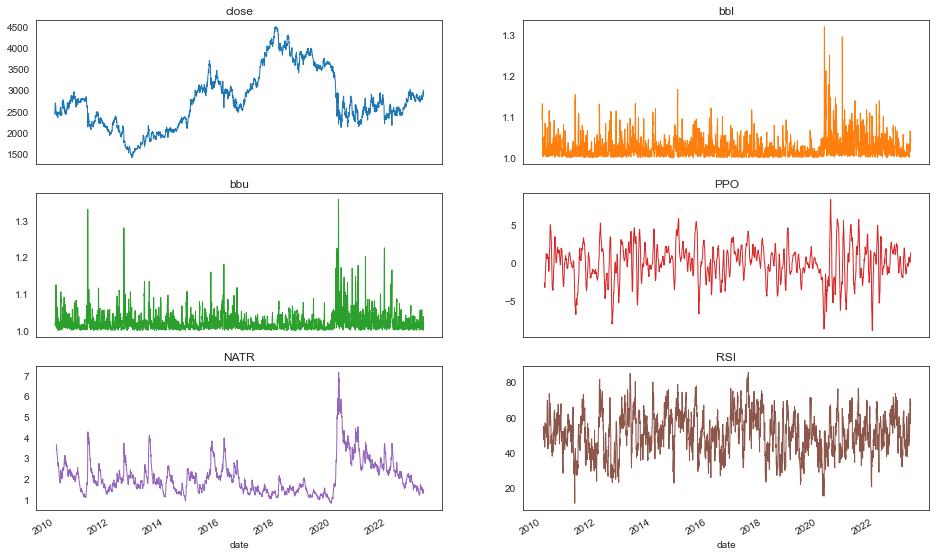

In [45]:
# Plot Indicators
indicators = ['close', 'bbl', 'bbu', 'PPO', 'NATR', 'RSI']
ticker = np.random.choice(data.index.get_level_values('ticker'))
(data.loc[idx[ticker, :], indicators].reset_index('ticker', drop=True).plot(lw=1, subplots=True, figsize=(16, 10), title=indicators, layout=(3, 2), legend=False))
plt.subtitle(ticker, fontsize=14)
sns.despine()
plt.subplots_adjust(.95)

In [46]:
data = data.drop(prices.columns, axis=1)
dates = data.index.get_level_values('date')
data['weekday'] = dates.weekday
data['month'] = dates.month
data['year'] = dates.year

outcomes=[]
by_ticker = data.groupby('ticker')
for t in intervals:
    k = f'fwd_ret_{t:02}'
    outcomes.append(k)
    data[k] = by_ticker[f'ret_{t}'].shift(-t)

data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3081645 entries, ('9984.JP', Timestamp('2010-01-04 00:00:00')) to ('3053.JP', Timestamp('2023-05-01 00:00:00'))
Data columns (total 23 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   ret_1            3080700 non-null  float64
 1   ret_rel_perc_1   3080700 non-null  float64
 2   ret_5            3076920 non-null  float64
 3   ret_rel_perc_5   3076920 non-null  float64
 4   ret_10           3072195 non-null  float64
 5   ret_rel_perc_10  3072195 non-null  float64
 6   ret_21           3061800 non-null  float64
 7   ret_rel_perc_21  3061800 non-null  float64
 8   ret_63           3022110 non-null  float64
 9   ret_rel_perc_63  3022110 non-null  float64
 10  PPO              3058020 non-null  float64
 11  NATR             3068415 non-null  float64
 12  RSI              3068415 non-null  float64
 13  bbl              3077865 non-null  float64
 14  bbu              3077865 non-nul

In [47]:
data.to_hdf('data/data.h5', 'stooq/japan/equities')